#### Overview:

This note book is meant to give an elaborate idea about the process used to access/understand the FIT.zip folder. It uses a tutorial based approach that can be used to get familiar with preliminary data preparing methods. The organization is as follows:

1. Single participant walkthrough:

- Going over the process for preparing the data for a single participant
    - Using the right python libraries
    - Accessing the zipped folder and extracting the data
    - Understanding the data organization and navigating through folders with python
    - (Minimally) preprocess/prepare the fitbit data
    - Visualize fitbit data, perform pearson's correlation

2. Combining different participant files:
- Main task: get one file for all participants
    - Using parts from part 1 to make functions
    - Combining all participant data into an excel file




#### 1. Single participant walkthrough

In [ ]:
# import libraries
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path

In [4]:
# access contents of the zip folder and extracting it

# note: we will be traversing many folders to see where the useful information lies

# extract zip file (make data accessible) 
zip_folder_path = r'C:\Users\s1081686\Desktop\tilburg_project\questions\FIT_study.zip'

accessible_data_path = r'C:\Users\s1081686\Desktop\tilburg_project\questions'
with zipfile.ZipFile(zip_folder_path, 'r') as zip_ref:
    zip_ref.extractall(accessible_data_path)

In [ ]:
# Visualize data organization (view truncated output only local machine)
# This is a function that can visually show us what the data organization looks like!

# prefix components:
space =  '    '
branch = '│   '
# pointers:
tee =    '├── '
last =   '└── '


def tree(dir_path: Path, prefix: str=''):
    """A recursive generator, given a directory Path object
    will yield a visual tree structure line by line
    with each line prefixed by the same characters
    """    
    contents = list(dir_path.iterdir())
    # contents each get pointers that are ├── with a final └── :
    pointers = [tee] * (len(contents) - 1) + [last]
    for pointer, path in zip(pointers, contents):
        yield prefix + pointer + path.name
        if path.is_dir(): # extend the prefix and recurse:
            extension = branch if pointer == tee else space 
            # i.e. space because last, └── , above so no more |
            yield from tree(path, prefix=prefix+extension)

print("data organization inside our questions folder:")            
for line in tree(dir_path=Path.home() / 'Desktop/tilburg_project/questions'):
    print(line)

In [5]:
# Now that we know what the organization looks like, we can now try to access it using python

# path for the folder containing data
study_folder = os.path.join(accessible_data_path,'FIT_study') 
  
# now lets pick one participant, and explore their data
example_participant = 'FIT04715'

example_participant_path = os.path.join(study_folder,example_participant) # the location of data for this participant
print('*'*50)
print("location for data of example participant",example_participant_path) 
print('*'*50)

# we will now store all locations inside our participant folder in a variable called paths (this is used later)
paths = [] # collect all paths that might be important to us
print("items inside the main folder of our participant:")
for dirs in os.listdir(example_participant_path):
    # this should look familiar. If it isn't, see previous cell's output!
    print("*"*50)
    print(f"sub folder: {dirs}")
    for items in os.listdir(os.path.join(example_participant_path,dirs)):
        print(f"content: {items}")  
        paths.append(os.path.join(example_participant_path,dirs,items))    
print('*'*50)


**************************************************
location for data of example participant C:\Users\s1081686\Desktop\tilburg_project\questions\FIT_study\FIT04715
**************************************************
items inside the main folder of our participant:
**************************************************
sub folder: 0e9VCY5vs7
content: match_fitcorp_heart_rate
content: match_fitcorp_steps
**************************************************
sub folder: 2jTAwSKo4w
content: match_fitcorp_heart_rate
content: match_fitcorp_steps
**************************************************


In [6]:
# Great, now that we have all locations stored, we will start collecting data for heart_rate and step folders!

# variables to store heart rate and steps data
data_hr = []
data_steps = []

# going over each stored location 
for path in paths:
    if 'steps' in path.split('\\')[-1].split('_'): # check if a folder name has 'steps' in it name, and then store it to the steps variable
        for file in set(os.listdir(path)):
            temp_steps_data = pd.read_csv(os.path.join(path,file))
            data_steps.append(temp_steps_data)
    elif 'heart' in path.split('\\')[-1].split('_'): # same logic for heart rate data
        for file in set(os.listdir(path)):
            temp_hr_data = pd.read_csv(os.path.join(path,file))
            data_hr.append(temp_hr_data)
        
# make data into presentable (convert to data frame)
data_hr = pd.concat(data_hr,ignore_index=True)
data_steps = pd.concat(data_steps,ignore_index=True) 

# print shape of data
print("steps data dimensions (rows x columns)", data_steps.shape)
print("heart rate data dimensions (rows x columns)", data_hr.shape)

steps data dimensions (rows x columns) (686, 3)
heart rate data dimensions (rows x columns) (644, 3)


In [7]:
# see what data looks like for our example participant
data_hr.sort_values(by='value.time').head(10)

,value.time,time.interval.minutes,value.heartRate.bpm
173,1620670860,60,65.5
495,1620670860,60,127.5
174,1620674940,60,56.6
496,1620674940,60,7.6
302,1621201560,60,62.2
624,1621201560,60,149.2
281,1621266780,60,82.3
603,1621266780,60,65.3
602,1621275780,60,94.2
280,1621275780,60,59.2


In [8]:
# and now for steps
data_steps.sort_values(by='value.time').head(10)

,value.time,time.interval.minutes,value.steps
184,1620670860,60,33
527,1620670860,60,33
185,1620674940,60,41
528,1620674940,60,37
444,1620829560,60,6
101,1620829560,60,0
323,1621201560,60,0
666,1621201560,60,0
645,1621266780,60,2244
302,1621266780,60,2236


In [9]:
# if you look closely at the two data stes:
# 1. The steps data set has a lot of 0 values in the last column
# 2. In both data sets, the value.Time column has multiple repeating values associated with different steps or heart rates.
# 3. The number of rows in the steps data does not match the number of rows in heart rate data!

# python can help us quantify all these points and also fix them
print(f"total entries with zeros in steps data set: {len(np.where(data_steps['value.steps']==0)[0])} out of {data_steps.shape[0]}")
print(f"number of repeating values in values.time for steps: {data_steps.shape[0] - len(np.unique(data_steps['value.time']))}")
print(f"number of repeating values in values.time for heart rate: {data_hr.shape[0] - len(np.unique(data_hr['value.time']))}")
print(f"absolute difference in number of rows for heart_rate and steps data: {abs(data_hr.shape[0] - data_steps.shape[0])}")

total entries with zeros in steps data set: 147 out of 686
number of repeating values in values.time for steps: 343
number of repeating values in values.time for heart rate: 322
absolute difference in number of rows for heart_rate and steps data: 42


In [10]:
# fix the problem of multiple entries of steps or heart rate for the same values.time:

# take average heart rate: we will average the heart rate for repeating instances of values.time
aggregated_hr = data_hr.groupby('value.time').agg({
        'time.interval.minutes': 'first',  # Assuming the interval is the same for all rows
        'value.heartRate.bpm': 'mean'      # Use average for heart rate
    }).reset_index().sort_values(by='value.time')


# take total steps: we add all the steps for repeating instances of values.time
aggregated_steps = data_steps.groupby('value.time').agg({
    'time.interval.minutes': 'first',
    'value.steps': 'mean'  # Use sum for steps
}).reset_index().sort_values(by='value.time')

# it seems we still have a mismatch, but unless if we fix this issue, we cannot find correlation between these variables!
print("difference in number of rows of steps and heart rate data",abs(aggregated_steps.shape[0]- aggregated_hr.shape[0]))

# merge data: pd.merge is a very useful function! It will merge the two data sets using the values.time column
# that also means that it will only use instances of the values.time column which have both a steps and heart rate data, 
# all other instances of values.time are removed
combined_data = pd.merge(aggregated_steps,aggregated_hr,on='value.time')

# remove zero values
combined_data =  combined_data[combined_data['value.steps'] > 0]

# lets see combined data
combined_data.head() # we can see that we have two identical columns, lets remove the duplicate column and rename the existing one


difference in number of rows of steps and heart rate data 21


,value.time,time.interval.minutes_x,value.steps,time.interval.minutes_y,value.heartRate.bpm
0,1620670860,60,33.0,60,96.50
1,1620674940,60,39.0,60,32.10
3,1621266780,60,2240.0,60,73.80
4,1621275780,60,294.0,60,76.70
5,1621517880,60,79.5,60,39.25


In [11]:
# remove duplicate columns like time.interval.minutes
combined_data = combined_data.drop(columns='time.interval.minutes_y')
combined_data = combined_data.rename(columns = {'time.interval.minutes_x':'time.interval.minutes'})

combined_data.head()

,value.time,time.interval.minutes,value.steps,value.heartRate.bpm
0,1620670860,60,33.0,96.50
1,1620674940,60,39.0,32.10
3,1621266780,60,2240.0,73.80
4,1621275780,60,294.0,76.70
5,1621517880,60,79.5,39.25


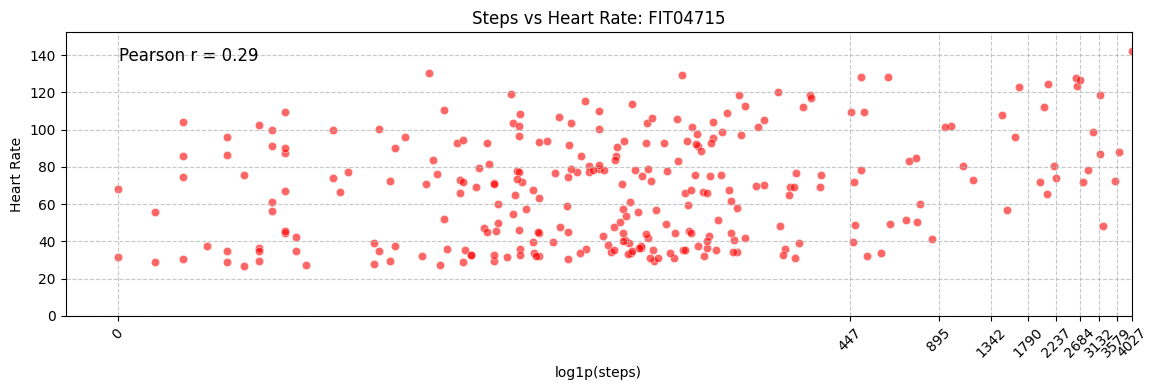

In [12]:
# let's visualize the data for a single participant and find the correlation between steps and heart rate
x = combined_data['value.steps']
y = combined_data['value.heartRate.bpm']

# get range
max_steps = x.max()
min_steps = x.min()

# create x ticks and vals
step_values = np.linspace(min_steps, max_steps, num=10)
log_ticks = np.log1p(step_values)
log_labels = [f'{int(val)}' for val in step_values]

# Log-transform the steps data
x_log = np.log1p(x)

plt.figure(figsize=(11.69, 4))
plt.scatter(x_log, y, alpha=0.6, c='r', edgecolors='w', linewidth=0.5)

# Set dynamic x-axis limits
plt.xlim(0, np.log1p(max_steps))
plt.ylim(0, y.max() + 10)  # Add some padding to the y-axis limit

# Set dynamic ticks
plt.xticks(ticks=log_ticks, labels=log_labels, rotation = 45)

plt.xlabel('log1p(steps)')
plt.ylabel('Heart Rate')
plt.title('Steps vs Heart Rate: FIT04715')

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add annotation for Pearson r
pearson_r = np.corrcoef(x, y)[0, 1]
plt.text(0.05, 0.95, f'Pearson r = {pearson_r:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# Display the plot
plt.tight_layout()
plt.show()


#### 2. Collecting Data for All Participants

In [13]:
participants = [i_par for i_par in os.listdir(study_folder)] # this list contains the IDs for all participants

print(participants)

['FIT04715', 'FIT05854', 'FIT12428', 'FIT14431', 'FIT16363', 'FIT17045', 'FIT21783', 'FIT23631', 'FIT26471', 'FIT27489', 'FIT47232', 'FIT48874', 'FIT49881', 'FIT53494', 'FIT60328', 'FIT75521', 'FIT76704', 'FIT82039', 'FIT86696', 'FIT89641', 'FIT94651', 'FIT99670']


In [14]:
# Reuse previous code to make functions. Note, this section may seem repetitive, but illustrates how useful python functions can be! 

def get_data_locations(study_folder:str,participant:str):
    """
    Get location of files for a participant

    Args:
        study_folder (str): location for the FIT_study folder
        participant (str): participant ID

    Returns:
        str: location of files for a participant
    """

    participant_path = os.path.join(study_folder,participant) # the location of data for a participant

    # we will now store all locations inside our participant folder in a variable called paths (this is used later)
    paths = [] # collect all paths that might be important to us

    for dirs in os.listdir(participant_path):
        # this should look familiar. If it isn't, see previous cell's output!
        for items in os.listdir(os.path.join(participant_path,dirs)):
            paths.append(os.path.join(participant_path,dirs,items)) 
            
    return paths   


def get_data_for_participant(participant_path:str):
    """
    Get heart rate and steps data for a participant

    Args:
        participant_path (str): location of files for a participant

    Returns:
        pandas.DataFrame: two pd.DataFrame objects with heart rate and steps data
    """
    # variables to store heart rate and steps data
    data_hr = [] # heart rate
    data_steps = [] 

    # going over each stored location 
    for path in participant_path:
        if 'steps' in path.split('\\')[-1].split('_'): # check if a folder name has 'steps' in it name, and then store it to the steps variable
            for file in set(os.listdir(path)):
                temp_steps_data = pd.read_csv(os.path.join(path,file))
                data_steps.append(temp_steps_data)
        elif 'heart' in path.split('\\')[-1].split('_'): # same logic for heart rate data
            for file in set(os.listdir(path)):
                temp_hr_data = pd.read_csv(os.path.join(path,file))
                data_hr.append(temp_hr_data)
            
    # make data into presentable (convert to data frame)
    data_hr = pd.concat(data_hr,ignore_index=True)
    data_steps = pd.concat(data_steps,ignore_index=True) 
    
    return data_hr,data_steps

def process_participant_data(data_hr:pd.DataFrame,data_steps:pd.DataFrame):
    """
    Minimally preprocess participant data

    Args:
        data_hr (pd.DataFrame): heart rate data
        data_steps (pd.DataFrame): steps data
    Returns:
        pd.DataFrame: the combined dataset that has heart rate and steps data together
    """
    # take average heart rate: we will average the heart rate for repeating instances of values.time
    aggregated_hr = data_hr.groupby('value.time').agg({
            'time.interval.minutes': 'first',  # Assuming the interval is the same for all rows
            'value.heartRate.bpm': 'mean'      # Use average for heart rate
        }).reset_index().sort_values(by='value.time')

    # take total steps: we add all the steps for repeating instances of values.time
    aggregated_steps = data_steps.groupby('value.time').agg({
        'time.interval.minutes': 'first',
        'value.steps': 'mean'  # Use sum for steps
    }).reset_index().sort_values(by='value.time')

    # merge data
    combined_data = pd.merge(aggregated_steps,aggregated_hr,on='value.time')
    
    # remove zero entries
    combined_data = combined_data[combined_data['value.steps'] > 0]
    
    # remove duplicate columns like time.interval.minutes
    combined_data = combined_data.drop(columns='time.interval.minutes_y')
    combined_data = combined_data.rename(columns = {'time.interval.minutes_x':'time.interval.minutes'})
    
    return combined_data
    
# additional: if you wish to visualize the data for a participant, try to write a function that does it! 
# the code for the plot is available in one of the previous cells
    

In [15]:
answers_path = r'C:\Users\s1081686\Desktop\tilburg_project\answers'
output_file = f"{answers_path}\\all_participants_data_FIT_study.xlsx" # every sheet inside the excel file corresponds to one participant

# Create a Pandas Excel writer using openpyxl as the engine
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for i_par, par in enumerate(participants):
        
        print(f"Starting cleaning process for participant {par}")
        
        # get path
        participant_path = get_data_locations(study_folder=study_folder, participant=par)
        
        # get participant data
        data_hr, data_steps = get_data_for_participant(participant_path=participant_path)
        
        # process participant data
        processed_data = process_participant_data(data_hr=data_hr, data_steps=data_steps)
        
        # Write the processed data to a sheet named after the participant
        sheet_name = f"Participant_{par}"
        processed_data.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Processed data saved to {output_file}")



Starting cleaning process for participant FIT04715
Starting cleaning process for participant FIT05854
Starting cleaning process for participant FIT12428
Starting cleaning process for participant FIT14431
Starting cleaning process for participant FIT16363
Starting cleaning process for participant FIT17045
Starting cleaning process for participant FIT21783
Starting cleaning process for participant FIT23631
Starting cleaning process for participant FIT26471
Starting cleaning process for participant FIT27489
Starting cleaning process for participant FIT47232
Starting cleaning process for participant FIT48874
Starting cleaning process for participant FIT49881
Starting cleaning process for participant FIT53494
Starting cleaning process for participant FIT60328
Starting cleaning process for participant FIT75521
Starting cleaning process for participant FIT76704
Starting cleaning process for participant FIT82039
Starting cleaning process for participant FIT86696
Starting cleaning process for p